# Behavioral User Identification from Mobile Motion Sensors

The goal of this project is to identify mobile users based on motion sensor behavior during interaction sessions.
Motion events are aggregated over short temporal windows and summarized into behavioral features at the session level, and a multi-class classification model is trained to identify the most likely user behind each session.

Key principles:
- Event-level → window-level → session-level aggregation
- Time-aware processing
- Sensor-specific feature extraction
- Session-level train/validation split (no leakage)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce
from scipy.stats import skew, kurtosis

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

## 1. Load raw event-level data and EDA
Each row corresponds to one sensor event.

In [3]:
df = pd.read_csv("/Users/emnabenothmen/Documents/mobile-behavioral-authentication/data/train.csv")
df.head()

,uid,timestamp,sensor_type,field_0,field_1,field_2,field_3,field_4,field_5,field_6,field_7,session_id,user_id
0,0157a1be-e373-4ca3-bc1f-f43885d11321,1758385959602,1,0.140499,0.403171,-0.185703,NaN,NaN,NaN,NaN,NaN,6c92cd0b-027c-4a0c-9802-4af636918681,e2ec300d-bbd6-4d29-a7c8-505970601891
1,04911357-2f63-4577-8c3b-0cd441319368,1758385960618,2,1.628057,4.774038,8.216900,NaN,NaN,NaN,NaN,NaN,6c92cd0b-027c-4a0c-9802-4af636918681,e2ec300d-bbd6-4d29-a7c8-505970601891
2,0554c28b-4992-4009-80e5-d4ce68236a03,1758385933842,2,0.737414,4.955997,9.150639,NaN,NaN,NaN,NaN,NaN,6c92cd0b-027c-4a0c-9802-4af636918681,e2ec300d-bbd6-4d29-a7c8-505970601891
3,0ad3f5f4-7266-4404-9f3a-3daae0486477,1758385977802,2,0.723049,6.138733,7.661446,NaN,NaN,NaN,NaN,NaN,6c92cd0b-027c-4a0c-9802-4af636918681,e2ec300d-bbd6-4d29-a7c8-505970601891
4,11137f53-7b69-4d79-a93e-8c87dae8f536,1758385922522,2,0.407014,5.559336,7.752425,NaN,NaN,NaN,NaN,NaN,6c92cd0b-027c-4a0c-9802-4af636918681,e2ec300d-bbd6-4d29-a7c8-505970601891


### Data Understanding & EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318350 entries, 0 to 2318349
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   uid          object 
 1   timestamp    int64  
 2   sensor_type  int64  
 3   field_0      float64
 4   field_1      float64
 5   field_2      float64
 6   field_3      float64
 7   field_4      float64
 8   field_5      float64
 9   field_6      float64
 10  field_7      float64
 11  session_id   object 
 12  user_id      object 
dtypes: float64(8), int64(2), object(3)
memory usage: 229.9+ MB


#### Sensor types present

In [5]:
df["sensor_type"].value_counts()

sensor_type
2     741521
1     333450
4     319168
6     313884
19    312335
5     297992
Name: count, dtype: int64

#### Events per session distribution

In [6]:
events_per_session = df.groupby("session_id").size()

events_per_session.describe()

count      300.000000
mean      7727.833333
std       6444.343697
min       1968.000000
25%       3976.250000
50%       5566.500000
75%       8724.000000
max      43288.000000
dtype: float64

#### Histogram

Text(0, 0.5, 'Number of sessions')

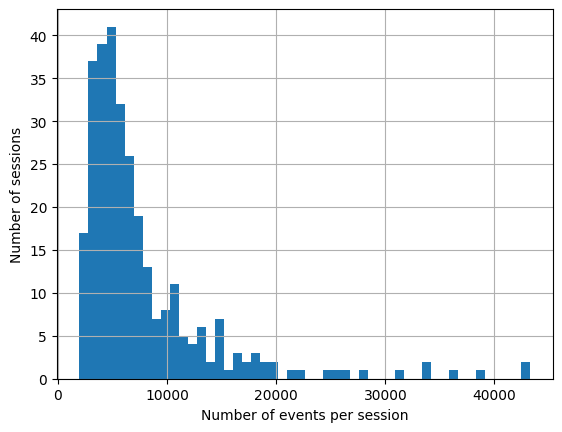

In [7]:
events_per_session.hist(bins=50)
plt.xlabel("Number of events per session")
plt.ylabel("Number of sessions")

In [8]:
df.groupby("sensor_type")[["field_0","field_1","field_2","field_3"]].count()

,field_0,field_1,field_2,field_3
sensor_type,,,,
1,333450,333450,333450,0
2,741521,741521,741521,0
4,319168,319168,319168,0
5,297992,297992,297992,0
6,313884,313884,313884,313884
19,312335,312335,312335,0


Text(0.5, 1.0, 'Raw accelerometer signals (sample)')

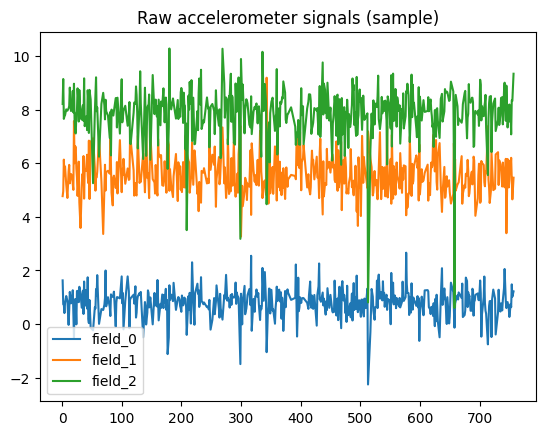

In [9]:
sample_session = df[df["sensor_type"] == 2].iloc[:500]

sample_session[["field_0","field_1","field_2"]].plot()
plt.title("Raw accelerometer signals (sample)")

In [10]:
sessions_per_user = df.groupby("user_id")["session_id"].nunique()

sessions_per_user.describe()

count    20.0
mean     15.0
std       0.0
min      15.0
25%      15.0
50%      15.0
75%      15.0
max      15.0
Name: session_id, dtype: float64

## 2. Basic preprocessing
- Convert timestamps
- Sort events chronologically
- Normalize null values
- Map sensor types

In [11]:
# Convert timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# Sort events (IMPORTANT for time-based features)
df = df.sort_values(["session_id", "timestamp"])

# Convert string "null" → NaN
df = df.replace("null", np.nan)

SENSOR_MAP = {
    1: "gyro",
    2: "acc",
    4: "gravity",
    5: "mag",
    19: "user_acc",
    6: "rotation"
}

df["sensor"] = df["sensor_type"].map(SENSOR_MAP)


## 3. Train / validation split (session-level)


In [12]:
sessions = df[["session_id", "user_id"]].drop_duplicates()

train_sessions, val_sessions = train_test_split(
    sessions,
    test_size=0.2,
    random_state=42,
    stratify=sessions["user_id"]
)

df_train = df[df["session_id"].isin(train_sessions["session_id"])]
df_val   = df[df["session_id"].isin(val_sessions["session_id"])]

# Safety check
assert set(df_train.session_id).isdisjoint(set(df_val.session_id))

#### checking (session_id, user_id) pairs

In [13]:
train_pairs = set(zip(df_train.session_id, df_train.user_id))
val_pairs   = set(zip(df_val.session_id, df_val.user_id))

assert train_pairs.isdisjoint(val_pairs)

## 4. Pivot sensor streams into wide time-aligned format

In [14]:
def pivot_sensor(df, sensor, fields):
    tmp = df[df["sensor"] == sensor][
        ["timestamp", "session_id", "user_id"] + fields
    ]
    tmp = tmp.rename(columns={f: f"{sensor}_{f}" for f in fields})
    return tmp


In [15]:
axes = ["field_0", "field_1", "field_2"]

def build_wide(df):
    gyro = pivot_sensor(df, "gyro", axes)
    acc = pivot_sensor(df, "acc", axes)
    gravity = pivot_sensor(df, "gravity", axes)
    mag = pivot_sensor(df, "mag", axes)
    user_acc = pivot_sensor(df, "user_acc", axes)

    rotation = pivot_sensor(
        df,
        "rotation",
        ["field_0", "field_1", "field_2", "field_3", "field_5", "field_6", "field_7"]
    ).rename(columns={
        "rotation_field_0": "rot_x",
        "rotation_field_1": "rot_y",
        "rotation_field_2": "rot_z",
        "rotation_field_3": "rot_scalar",
        "rotation_field_5": "pitch",
        "rotation_field_6": "roll",
        "rotation_field_7": "yaw",
    })

    dfs = [gyro, acc, gravity, mag, user_acc, rotation]

    data = reduce(
        lambda left, right: pd.merge(
            left, right,
            on=["timestamp", "session_id", "user_id"],
            how="outer"
        ),
        dfs
    )

    return data.sort_values(["session_id", "timestamp"])


In [16]:
data_train = build_wide(df_train)
data_val   = build_wide(df_val)

In [17]:
assert set(data_train.session_id).isdisjoint(set(data_val.session_id))

assert set(zip(data_train.session_id, data_train.user_id)).isdisjoint(
    set(zip(data_val.session_id, data_val.user_id))
)

## 5. Temporal windowing
We aggregate sensor data into short fixed windows.

In [18]:
WINDOW_SIZE = "2s"

def add_windows(data):
    data = data.copy()
    data["window_id"] = (
        data
        .groupby("session_id")["timestamp"]
        .transform(lambda x: x.dt.floor(WINDOW_SIZE))
    )
    return data

In [19]:
data_train = add_windows(data_train)
data_val   = add_windows(data_val)

## 6. Feature extraction per window

In [20]:
def stats(series, prefix):
    series = series.dropna()
    if len(series) == 0:
        return {}

    return {
        f"{prefix}_mean": series.mean(),
        f"{prefix}_std": series.std(),
        f"{prefix}_min": series.min(),
        f"{prefix}_max": series.max(),
        f"{prefix}_skew": skew(series),
        f"{prefix}_kurtosis": kurtosis(series),
        f"{prefix}_energy": np.mean(series ** 2),
    }


In [21]:
#Window feature extractor
def extract_features(window):
    features = {}

    sensors = ["gyro", "acc", "gravity", "mag", "user_acc"]

    for s in sensors:
        x = window.get(f"{s}_field_0")
        y = window.get(f"{s}_field_1")
        z = window.get(f"{s}_field_2")

        if x is None:
            continue

        norm = np.sqrt(x**2 + y**2 + z**2)

        features.update(stats(norm, f"{s}_norm"))
        features.update(stats(x, f"{s}_x"))
        features.update(stats(y, f"{s}_y"))
        features.update(stats(z, f"{s}_z"))

    for angle in ["yaw", "pitch", "roll"]:
        if angle in window:
            features.update(stats(window[angle], angle))

    if "rot_scalar" in window:
        theta = 2 * np.arccos(window["rot_scalar"].dropna())
        features.update(stats(theta, "rotation_angle"))

    return features

In [22]:
def build_session_features(data):
    window_features = []

    for (session_id, window_id), window in data.groupby(["session_id", "window_id"]):
        feats = extract_features(window)
        feats["session_id"] = session_id
        feats["user_id"] = window["user_id"].iloc[0]
        window_features.append(feats)

    window_df = pd.DataFrame(window_features)

    numeric_cols = window_df.select_dtypes(include=[np.number]).columns

    session_features = (
        window_df
        .groupby("session_id")[numeric_cols]
        .agg(["mean", "std"])
    )

    session_features.columns = [
        f"{c[0]}_{c[1]}" for c in session_features.columns
    ]

    session_features = session_features.reset_index()

    labels = (
        window_df
        .groupby("session_id")["user_id"]
        .first()
        .reset_index()
    )
    

    return session_features.merge(labels, on="session_id")

## 7. Aggregate window features to session-level

In [23]:
def build_session_features(data):
    window_features = []

    for (session_id, window_id), window in data.groupby(["session_id", "window_id"]):
        feats = extract_features(window)
        feats["session_id"] = session_id
        feats["user_id"] = window["user_id"].iloc[0]
        window_features.append(feats)

    window_df = pd.DataFrame(window_features)

    numeric_cols = window_df.select_dtypes(include=[np.number]).columns

    session_features = (
        window_df
        .groupby("session_id")[numeric_cols]
        .agg(["mean", "std"])
    )

    session_features.columns = [
        f"{c[0]}_{c[1]}" for c in session_features.columns
    ]

    session_features = session_features.reset_index()

    labels = (
        window_df
        .groupby("session_id")["user_id"]
        .first()
        .reset_index()
    )

    return session_features.merge(labels, on="session_id")

In [24]:
train_sessions_df = build_session_features(data_train)
val_sessions_df   = build_session_features(data_val)

/var/folders/17/yy4d49491b35v02b9rsykhg80000gn/T/ipykernel_43381/3531320923.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f"{prefix}_skew": skew(series),
/var/folders/17/yy4d49491b35v02b9rsykhg80000gn/T/ipykernel_43381/3531320923.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f"{prefix}_kurtosis": kurtosis(series),
/var/folders/17/yy4d49491b35v02b9rsykhg80000gn/T/ipykernel_43381/3531320923.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f"{prefix}_skew": skew(series),
/var/folders/17/yy4d49491b35v02b9rsykhg80000gn/T/ipykernel_43381/3531320923.py:12: RuntimeWarning: Precision loss occurred in mo

In [25]:
X_train = train_sessions_df.drop(columns=["session_id", "user_id"]).fillna(0)
y_train = train_sessions_df["user_id"]

X_val = val_sessions_df.drop(columns=["session_id", "user_id"]).fillna(0)
y_val = val_sessions_df["user_id"]

# Safety check
assert list(X_train.columns) == list(X_val.columns)


## 8. Train Baseline Model : Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=3,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced"
    )

In [27]:
#train the model
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

## 9. Model Evaluation

In [28]:
import numpy as np

def top_k_accuracy(model, X, y, k=3):
    """
    Computes Top-K accuracy for multiclass classification.
    """
    probs = model.predict_proba(X)
    top_k_idx = np.argsort(probs, axis=1)[:, -k:]
    classes = model.classes_

    correct = [
        y.iloc[i] in classes[top_k_idx[i]]
        for i in range(len(y))
    ]
    return np.mean(correct)

In [29]:
from sklearn.metrics import accuracy_score, f1_score

# Predict
y_val_pred = model.predict(X_val)

# Metrics
acc = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average="macro")
top3 = top_k_accuracy(model, X_val, y_val, k=3)
top5 = top_k_accuracy(model, X_val, y_val, k=5)

print(f"Accuracy     : {acc:.4f}")
print(f"Macro F1     : {f1:.4f}")
print(f"Top-3 Acc    : {top3:.4f}")
print(f"Top-5 Acc    : {top5:.4f}")

Accuracy     : 0.8833
Macro F1     : 0.8782
Top-3 Acc    : 0.9833
Top-5 Acc    : 1.0000


## Cross-Validation 

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [31]:
X_cv = pd.concat([X_train, X_val], axis=0)
y_cv = pd.concat([y_train, y_val], axis=0) 

X_cv = X_cv.reset_index(drop=True)
y_cv = y_cv.reset_index(drop=True)

assert len(X_cv) == len(y_cv)
assert X_cv.shape[0] == y_cv.shape[0]

In [32]:
cv_results = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_cv, y_cv), 1):
    X_cv_train, X_cv_val = X_cv.iloc[train_idx], X_cv.iloc[val_idx]
    y_cv_train, y_cv_val = y_cv.iloc[train_idx], y_cv.iloc[val_idx]

    rf = RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=3,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced"
    )

    rf.fit(X_cv_train, y_cv_train)

    y_cv_val_pred = rf.predict(X_cv_val)

    fold_metrics = {
        "fold": fold,
        "accuracy": accuracy_score(y_cv_val, y_cv_val_pred),
        "macro_f1": f1_score(y_cv_val, y_cv_val_pred, average="macro"),
        "top3_acc": top_k_accuracy(rf, X_cv_val, y_cv_val, k=3),
        "top5_acc": top_k_accuracy(rf, X_cv_val, y_cv_val, k=5),
    }

    cv_results.append(fold_metrics)

In [33]:
import pandas as pd

cv_df = pd.DataFrame(cv_results)
cv_df

,fold,accuracy,macro_f1,top3_acc,top5_acc
0,1,0.916667,0.917024,1.000000,1.000000
1,2,0.866667,0.853810,0.933333,0.966667
2,3,0.883333,0.876905,0.983333,1.000000
3,4,0.866667,0.867024,0.966667,0.983333
4,5,0.900000,0.889405,1.000000,1.000000


In [34]:
cv_summary = cv_df.drop(columns="fold").agg(["mean", "std"])
cv_summary

,accuracy,macro_f1,top3_acc,top5_acc
mean,0.886667,0.880833,0.976667,0.990000
std,0.021731,0.024081,0.027889,0.014907


### Cross-Validation Results

We performed 5-fold cross-validation using a Random Forest model on the combined
training and validation dataset.

- Mean CV score: **0.88**
- Standard deviation: **0.02**

The high mean performance indicates strong predictive capability, while the low
standard deviation suggests the model is stable and not overly sensitive to the
choice of training/validation split. This confirms that the previously observed
validation performance was not due to a favorable split.

Based on these results, the Random Forest model generalizes well and is suitable
for final training.

### Comparison with Single Split Results

The consistency between single-split and cross-validation metrics indicates stable generalization and absence of overfitting.

High Top-K accuracy across both evaluation strategies suggests that user behavioral patterns are strongly captured and consistently ranked.


## 10. Feature importance

## Extract feature importance per fold

In [ ]:
import numpy as np

importances = []

for train_idx, val_idx in cv.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]

    rf = RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=3,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced"
    )

    rf.fit(X_train, y_train)
    importances.append(rf.feature_importances_)

In [ ]:
importances = np.array(importances)

feature_importance_cv = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": importances.mean(axis=0),
    "importance_std": importances.std(axis=0),
}).sort_values("importance_mean", ascending=False)

feature_importance_cv.head(20)

,feature,importance_mean,importance_std
68,acc_norm_energy_mean,0.027472,0.002387
56,acc_norm_mean_mean,0.026286,0.001524
124,gravity_norm_energy_mean,0.020919,0.001346
116,gravity_norm_min_mean,0.020731,0.001793
118,gravity_norm_max_mean,0.018347,0.001213
112,gravity_norm_mean_mean,0.017672,0.001326
178,mag_norm_kurtosis_mean,0.011892,0.001352
190,mag_x_skew_mean,0.011883,0.002143
177,mag_norm_skew_std,0.011182,0.001313
32,gyro_y_min_mean,0.010669,0.000669


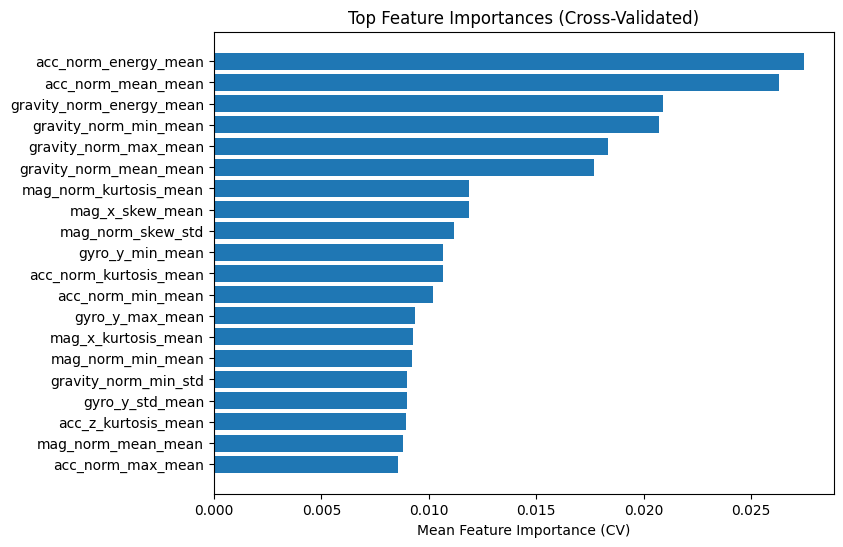

In [ ]:
import matplotlib.pyplot as plt

top_n = 20

plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_cv["feature"].head(top_n)[::-1],
    feature_importance_cv["importance_mean"].head(top_n)[::-1]
)
plt.xlabel("Mean Feature Importance (CV)")
plt.title("Top Feature Importances (Cross-Validated)")
plt.show()

## Sensor-level aggregation 

In [ ]:
def extract_sensor_name(feature):
    for s in ["gyro", "acc", "gravity", "mag", "user_acc", "rotation", "yaw", "pitch", "roll"]:
        if feature.startswith(s):
            return s
    return "other"

feature_importance_cv["sensor"] = feature_importance_cv["feature"].apply(extract_sensor_name)

sensor_importance = (
    feature_importance_cv
    .groupby("sensor")["importance_mean"]
    .sum()
    .sort_values(ascending=False)
)

sensor_importance

sensor
mag         0.236050
acc         0.196551
gravity     0.188074
gyro        0.151689
user_acc    0.125953
roll        0.031966
yaw         0.031163
pitch       0.022382
rotation    0.016172
Name: importance_mean, dtype: float64

## Select features via cumulative importance

In [ ]:
feature_importance_cv["cum_importance"] = (
    feature_importance_cv["importance_mean"].cumsum()
)

selected_features = feature_importance_cv[
    feature_importance_cv["cum_importance"] <= 0.90
]["feature"].tolist()

len(selected_features), len(X.columns)


(220, 336)

In [ ]:
cv_results_iter = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx][selected_features], X.iloc[val_idx][selected_features]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    rf = RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=3,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced"
    )

    rf.fit(X_train, y_train)

    y_val_pred = rf.predict(X_val)

    cv_results_iter.append({
        "fold": fold,
        "accuracy": accuracy_score(y_val, y_val_pred),
        "macro_f1": f1_score(y_val, y_val_pred, average="macro"),
        "top3_acc": top_k_accuracy(rf, X_val, y_val, k=3),
        "top5_acc": top_k_accuracy(rf, X_val, y_val, k=5),
    })

## Compare baseline vs iteration

In [ ]:
cv_iter_df = pd.DataFrame(cv_results_iter)

comparison = pd.DataFrame({
    "metric": ["accuracy", "macro_f1", "top3_acc", "top5_acc"],
    "baseline_mean": cv_df.drop(columns="fold").mean().values,
    "iter_mean": cv_iter_df.drop(columns="fold").mean().values,
})

comparison

,metric,baseline_mean,iter_mean
0,accuracy,0.886667,0.870833
1,macro_f1,0.880833,0.858762
2,top3_acc,0.976667,0.983333
3,top5_acc,0.990000,0.995833


Feature selection based on cumulative importance improved Top-K identification accuracy but slightly reduced Top-1 accuracy and Macro-F1. Since the primary objective is exact user identification, the baseline model was retained for final submission. The feature-reduced model is presented as a robustness analysis, highlighting trade-offs between discriminative power and generalization.

## Final conclusions

- Motion sensor data contains stable, user-specific behavioral signatures
- Short temporal windows capture fine-grained movement dynamics
- Aggregating window statistics yields robust session-level representations
- Random Forest models can accurately identify users from motion behavior

This approach is well-suited for:
- Passive authentication
- Fraud detection
- Continuous user verification

## Prepare Test Features (Same Pipeline)

In [ ]:
df_test = pd.read_csv("/Users/emnabenothmen/Documents/mobile-behavioral-authentication/data/test.csv")
df_test.head()

,uid,timestamp,sensor_type,field_0,field_1,field_2,field_3,field_4,field_5,field_6,field_7,session_id
0,00fb2624-996e-4dde-a9b9-5a0d6784abfa,1755089347628,1,0.023366,0.043524,0.067501,NaN,NaN,NaN,NaN,NaN,a47ea05f-68b6-4e84-8591-db9580d58ce6
1,03b1d813-f3e1-481f-b523-8470ba81fb96,1755089326732,6,0.388720,0.403039,0.658245,0.503161,-1.0,-1.183342,-0.263185,-2.053627,a47ea05f-68b6-4e84-8591-db9580d58ce6
2,0995b64c-693c-4fc1-ac12-5d3e5e4d253c,1755089328671,4,0.751356,9.419654,2.622206,NaN,NaN,NaN,NaN,NaN,a47ea05f-68b6-4e84-8591-db9580d58ce6
3,0a852d2e-c12c-4b71-9f79-d801ce07c9f2,1755089369479,2,-0.311067,9.467801,2.925226,NaN,NaN,NaN,NaN,NaN,a47ea05f-68b6-4e84-8591-db9580d58ce6
4,1df4588a-5f0f-46e6-bcd2-38e750eec0a7,1755089230747,2,1.351945,9.412168,2.305485,NaN,NaN,NaN,NaN,NaN,a47ea05f-68b6-4e84-8591-db9580d58ce6


In [ ]:
# Convert timestamp
df_test["timestamp"] = pd.to_datetime(df_test["timestamp"], unit="ms")

# Sort
df_test = df_test.sort_values(["session_id", "timestamp"])

# Convert string "null" → NaN
df_test = df_test.replace("null", np.nan)

# Map sensors
df_test["sensor"] = df_test["sensor_type"].map(SENSOR_MAP)

In [ ]:
def pivot_sensor_test(df, sensor, fields):
    tmp = df[df["sensor"] == sensor][
        ["timestamp", "session_id"] + fields
    ]
    tmp = tmp.rename(columns={f: f"{sensor}_{f}" for f in fields})
    return tmp

axes = ["field_0", "field_1", "field_2"]

gyro = pivot_sensor_test(df_test, "gyro", axes)
acc = pivot_sensor_test(df_test, "acc", axes)
gravity = pivot_sensor_test(df_test, "gravity", axes)
mag = pivot_sensor_test(df_test, "mag", axes)
user_acc = pivot_sensor_test(df_test, "user_acc", axes)

rotation = pivot_sensor_test(
    df_test,
    "rotation",
    ["field_0", "field_1", "field_2", "field_3", "field_5", "field_6", "field_7"]
)

rotation = rotation.rename(columns={
    "rotation_field_0": "rot_x",
    "rotation_field_1": "rot_y",
    "rotation_field_2": "rot_z",
    "rotation_field_3": "rot_scalar",
    "rotation_field_5": "pitch",
    "rotation_field_6": "roll",
    "rotation_field_7": "yaw",
})

In [ ]:
from functools import reduce

dfs = [gyro, acc, gravity, mag, user_acc, rotation]

test_data = reduce(
    lambda left, right: pd.merge(
        left, right,
        on=["timestamp", "session_id"],
        how="outer"
    ),
    dfs
)

test_data = test_data.sort_values("timestamp")

In [ ]:
WINDOW_SIZE = "2s"

test_data["window_id"] = (
    test_data
    .groupby("session_id")["timestamp"]
    .transform(lambda x: x.dt.floor(WINDOW_SIZE))
)

In [ ]:
from scipy.stats import skew, kurtosis

def stats(series, prefix):
    series = series.dropna()
    if len(series) == 0:
        return {}

    return {
        f"{prefix}_mean": series.mean(),
        f"{prefix}_std": series.std(),
        f"{prefix}_min": series.min(),
        f"{prefix}_max": series.max(),
        f"{prefix}_skew": skew(series),
        f"{prefix}_kurtosis": kurtosis(series),
        f"{prefix}_energy": np.mean(series ** 2),
    }

def extract_features(window):
    features = {}

    sensors = ["gyro", "acc", "gravity", "mag", "user_acc"]

    for s in sensors:
        x = window[f"{s}_field_0"]
        y = window[f"{s}_field_1"]
        z = window[f"{s}_field_2"]

        norm = np.sqrt(x**2 + y**2 + z**2)
        features.update(stats(norm, f"{s}_norm"))

        features.update(stats(x, f"{s}_x"))
        features.update(stats(y, f"{s}_y"))
        features.update(stats(z, f"{s}_z"))

    for angle in ["yaw", "pitch", "roll"]:
        features.update(stats(window[angle], angle))

    theta = 2 * np.arccos(window["rot_scalar"].dropna())
    features.update(stats(theta, "rotation_angle"))

    return features

In [ ]:
test_window_features = []

for (session_id, window_id), window in test_data.groupby(
    ["session_id", "window_id"]
):
    feats = extract_features(window)
    feats["session_id"] = session_id
    feats["window_id"] = window_id
    test_window_features.append(feats)

test_window_df = pd.DataFrame(test_window_features)
test_window_df.head()

/var/folders/17/yy4d49491b35v02b9rsykhg80000gn/T/ipykernel_35543/937808285.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f"{prefix}_skew": skew(series),
/var/folders/17/yy4d49491b35v02b9rsykhg80000gn/T/ipykernel_35543/937808285.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f"{prefix}_kurtosis": kurtosis(series),


,gyro_norm_mean,gyro_norm_std,gyro_norm_min,gyro_norm_max,gyro_norm_skew,gyro_norm_kurtosis,gyro_norm_energy,gyro_x_mean,gyro_x_std,gyro_x_min,...,roll_energy,rotation_angle_mean,rotation_angle_std,rotation_angle_min,rotation_angle_max,rotation_angle_skew,rotation_angle_kurtosis,rotation_angle_energy,session_id,window_id
0,0.242273,0.175813,0.020338,0.764944,1.365875,1.782177,0.088201,-0.054152,0.116948,-0.407142,...,0.013180,1.352728,0.012559,1.333054,1.377206,0.138590,-0.676269,1.830022,09b6a173-50a8-48e6-8af5-4e4c4627bb16,2025-06-24 09:54:12
1,0.249351,0.281939,0.023935,1.026557,1.875571,2.172704,0.139328,-0.001761,0.245971,-0.694096,...,0.021755,1.347671,0.030781,1.304094,1.392294,-0.178426,-1.408612,1.817131,09b6a173-50a8-48e6-8af5-4e4c4627bb16,2025-06-24 09:54:14
2,0.227260,0.194768,0.011483,0.786717,1.057664,0.652951,0.088274,0.013360,0.204628,-0.520915,...,0.062192,1.298134,0.025661,1.236091,1.318318,-1.624929,0.988021,1.685793,09b6a173-50a8-48e6-8af5-4e4c4627bb16,2025-06-24 09:54:16
3,0.184143,0.189408,0.004925,0.981839,2.673630,8.373087,0.068627,-0.005803,0.158139,-0.271377,...,0.041373,1.272083,0.035903,1.242781,1.348122,1.315890,0.023183,1.619434,09b6a173-50a8-48e6-8af5-4e4c4627bb16,2025-06-24 09:54:18
4,0.265789,0.142282,0.061167,0.661769,0.699677,0.331872,0.090292,0.053055,0.208198,-0.470519,...,0.075701,1.318205,0.025703,1.290309,1.370417,0.448650,-1.189348,1.738301,09b6a173-50a8-48e6-8af5-4e4c4627bb16,2025-06-24 09:54:20


In [ ]:
numeric_cols = test_window_df.select_dtypes(include=[np.number]).columns

test_session_features = (
    test_window_df
    .groupby("session_id")[numeric_cols]
    .agg(["mean", "std"])
)

test_session_features.columns = [
    f"{c[0]}_{c[1]}" for c in test_session_features.columns
]

test_session_features = test_session_features.reset_index()


In [ ]:
X_test = test_session_features.set_index("session_id")
X_test = X_test.fillna(0)

X_test.shape

(96, 336)

In [ ]:
X = X_cv

# X is your training matrix
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

extra_cols = set(X_test.columns) - set(X.columns)
X_test = X_test.drop(columns=extra_cols)

X_test = X_test[X.columns]

In [ ]:
train_features = X.columns.tolist()
len(train_features)

# Drop extra columns from test
X_test_aligned = X_test[train_features]


In [ ]:
assert list(X_test_aligned.columns) == train_features
print("Test features aligned with training features")


Test features aligned with training features


## Predict User IDs on Test Set

In [ ]:
test_preds = model.predict(X_test_aligned)

In [ ]:
submission = pd.DataFrame({
    "session_id": X_test.index,
    "user_id": test_preds
})

submission.head()

,session_id,user_id
0,09b6a173-50a8-48e6-8af5-4e4c4627bb16,ea6b88b1-d76a-4605-adfe-30b547fc5156
1,0d7b1486-861f-4791-9c2c-4f5582717780,88ebe9b3-59ff-4273-a240-c1274705e361
2,11aaf409-d723-4825-b237-35f7e75cb67c,e98939a8-40b0-495c-8cbe-28be80244a13
3,127a5dad-0489-4d0c-8734-3a6d8f6508c3,88ebe9b3-59ff-4273-a240-c1274705e361
4,18073593-db19-4dc9-a05b-cbb4f16badd7,c05b7e4d-2104-4078-997e-53e31c85f0de


In [ ]:
submission.to_csv("/Users/emnabenothmen/Documents/mobile-behavioral-authentication/data/submission.csv", index=False)